# Randomization analysis

In this notebook we investigate whether interactions with an unbalance of simple and twisted read pairs occur more often than expected by chance. Similar to the FDR procedure, we randomize the simple and twisted read pair counts in each interaction according to a binomial distribution with $p=0.5$ and then determine the total number of significant interactions at a given nominal alpha. But instead of doing only one iteration of this procedure, as we do for estimating the FDR, we do many interations, e.g. ``10,000``. If we never observe more significant interactions than for the non-randomized data, we speak of an empirical P-value of ``1/10000``. In addition, we calculate the mean and standard devaition for the numbers of randomized significant interactions from all iterations, and from this, in turn, a Z-score. Finally, we estimate the FDR from the mean number of significant interactions after randomization and the number of significant interactions originally observed.

## Setting up the notebook

In [1]:
import sys
import os
import numpy as np
import pandas
sys.path.append("..")
import matplotlib.pyplot as plt
%matplotlib inline


from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

In this notebook, we use the following classes and functions:
* ``DiachromaticInteractionSet``
    - ``parse_file``: Read interactions from file
    - ``get_read_file_info_report``: Get information about files that have already been read in form of a formatted string
* ``RandomizeInteractionSet``
    - ``perform_randomization_analysis``: The entire randomzation analysis is carried out in this function using sub-functions that are also used for the FDR procedure, which is also implemented in ``RandomizeInteractionSet``
    - ``get_randomization_info_report``: Get information about randomization analysis in form of a formatted string
    - ``get_randomization_info_plot``: Get information about randomization analysis in form of a plot

We use the ``DiachromaticInteractionSet`` to read interactions from a file. The FDR procedure is carried out in class ``RandomizeInteractionSet``, which operates on an already existing ``DiachromaticInteractionSet`` object that has been passed to its constructor.

## Test files

### Test file 1

We use the test files with ``1,000`` to ``64,000`` interactions, which we also use to test the FDR procedure.

In [2]:
ls ../tests/data/test_03/*top_*

../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_16000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_32000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz


## Demonstration of the analysis using the test file with ``64,000`` interactions

First, we read the interaction file into an interaction set.

In [3]:
interaction_set_64000 = DiachromaticInteractionSet()
interaction_set_64000.parse_file('../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz', verbose=True)
read_file_info_report_64000 = interaction_set_64000.get_read_file_info_report()
print(read_file_info_report_64000)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
[INFO] ... done.
[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 64,000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
			[INFO] Set size: 64,000
	[INFO] The interaction set has 64,000 interactions.
[INFO] End of report.



Next, we create an object of class ``RandomizeInteractionSet`` and pass the interaction set to this object. Furthermore, a random seed can specified so that the results are reproducible. If no random seed is passed to the constructor, a random seed is generated from the system time.

In [4]:
randomization_analysis_64000 = RandomizeInteractionSet(
    interaction_set = interaction_set_64000,
    random_seed = 0)

### Randomization parameters

Then we call the function ``perform_randomization_analysis`` of the class ``RandomizeInteractionSet`` in which the entire randomization analysis is implemented. To this function, a ``nominal_alpha`` is passed, which is used as the P-value threshold. Interactions that have a smaller P-value are counted as significant. In addition, the number of iterations can be specified (``iter_num`` defaults to ``1,000``). From the random seed passed to the constructor or the random seed from the system time, a further random seed is derived by adding for each iteration by adding the index of the iteration (``0, 1, 2, ...``). In this way, the results for a given random seed remain the same, regardless of the degree of parallelization.

### Paralell processing

Dependinng on the innput parameters, the analysis can be computational intensive. Therefore, batches of iterations can be carried out in paralell processes. If ``thread_num = 0`` (default), the Python package ``multiprocessing`` is not used and all iterations are performed in sequence. If ``thread_num = 1``, then the ``multiprocessing`` package is used, but all iterations are performed in a single process. If ``1 < thread_num``, the iterations are divided into batches that are performed in paralell processes. We implemented this in this way in order to be able to test the parallelization in a unit test.

In [8]:
randomization_analysis_64000_info_dict = randomization_analysis_64000.perform_randomization_analysis(
    nominal_alpha = 0.005,
    iter_num = 1000,
    thread_num = 2,
    verbose = True)

[INFO] Performing randomization analysis with 1000 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Performing 500 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
		[INFO] Performing 500 iterations ...
			[INFO] First iteration indices: 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, ...
	[INFO] Calculating summary statistics ...
[INFO] ... done.


If we call the function with ``verbose = True``, progress messages are output. In this case, we have set ``thread_num = 2`` so that ``500`` iterations are performed in two parallel proccesses.

### Results

The function ``perform_randomization_analysis`` returns a dictionary that contains all information about the analysis performed. The main results can be presented in a pandas ``DataFrame`` as follows:

In [9]:
pandas.DataFrame(randomization_analysis_64000_info_dict['RESULTS']['SUMMARY'])

,SIG_NUM_O,I_NUM_RANDOMIZED,SIG_NUM_R_GT_OBS,SIG_NUM_R_MEAN,SIG_NUM_R_STD,Z_SCORE,FDR
0,1783,42792,0,114.486,10.880984,153.342203,0.06421


Alternatively, all information about the analysis can be presented as a formatted string as follows:

In [10]:
print(randomization_analysis_64000.get_randomization_info_report())

[INFO] Report on randomization analysis:
	[INFO] Input parameters:
		[INFO] Number of input interactions: 64,000
		[INFO] Nominal alpha: 0.00500
		[INFO] Number of iterations: 1,000
		[INFO] Random seed: 0
	[INFO] Results:
		[INFO] Original number of significant interactions: 1,783
		[INFO] Number of randomized interactions: 42,792
		[INFO] First 10 significant randomized interaction numbers: 
			117, 111, 106, 118, 112, 98, 119, 119, 91, 106, ...
		[INFO] Iterations with more significant interactions than observed: 0
		[INFO] Mean number of significant randomized interactions: 114.49
		[INFO] Standard deviation of significant randomized interactions: 10.88
		[INFO] Z-score: 153.34
		[INFO] Estimated FDR: 0.06421
[INFO] End of report.



The first section of the report shows the input parameters. For this analysis, we used an input file with ``64,000`` interactions. Interactions with a P-value smaller than the chosen nominal alpha (``0.005``) were classified as significant and ``1,000`` iterations were performed. For the randomizations, we used random seeds that correspond to the iteration index plus ``0``. The second section of the report contains the results. At the chosen nominal alpha, ``1,783`` non-randomized input interactions were classified as significant. We only randomize interactions that have enough read pairs to order to be significant. At the chosen nominal alpha, ``42,792`` of the ``64,000`` interactions have enough read pairs (``9``) in order to be significant and were randomized. The numbers of randomized significant interactions for the first iterations were: ``117, 111, 106, ...``. There was no iteration (``0``) with more significant interactions than originally observed. The average number of randomized significant interactions over all iterations is ``114.49``, and the standard  deviation is ``10.88``. This results in a Z-score of ``153.34``. The number of significant interactions before randomization and the mean number of significant interactions after randomization results in an estimated FDR of  ``114.49/1783 = 0.06421``.

Finally, the function ``get_randomization_info_plot`` can be used to create a plot that shows the numbers of ranndomized significant interactions from all iterations in a histogram.

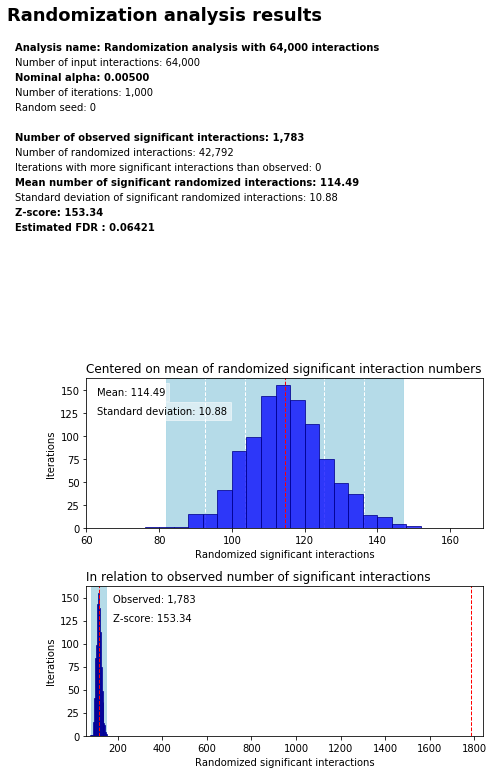

In [11]:
# Create plot with a histogram for the randomized significant interaction numbers from all iterations
fig = randomization_analysis_64000.get_randomization_info_plot(
    pdf_file_name = 'randomization_analysis_64000.pdf',
    analysis_name = 'Randomization analysis with 64,000 interactions')

The header of the plot contains all the information about the analysis that is also contained in the formatted string decribed above. Below that, there are two histograms that show the distribution of the numbers of randomized significant interactions from all iterations. The upper histogram is centered on the mean at which a red dashed line is drawn. In addition, the range of three standard deviations to the left and right of the mean is highlighted in light blue. The lower histogram shows the same data in relation to the originally observed number of significant interactions at which a second red dashed line is drawn.

## Results of the randomization depending on the number of iterations

In this section, we examine the relationship between the number of iterations and the mean number of randomized significant interactions as well the associated standard deviation and Z-score. To do this, we perform the randomization analysis with a nominal alpha of ``0.005`` for increasing numbers of iterations using the input file with ``64,000`` interactions.

In [12]:
# Input parameters
iter_nums = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
nominal_alpha = 0.005

# Dictionary to save the results for increasing numbers of iterations
results_iter_num = {}

# Perform randomization analyzes
for iter_num in iter_nums:   
    print('Performing randomization analysis with ' + "{:,}".format(iter_num) + ' iterations ...')
    results_iter_num[iter_num] = randomization_analysis_64000.perform_randomization_analysis(
    nominal_alpha = nominal_alpha,
    iter_num = iter_num,
    thread_num = 2,
    verbose = False)
print('... done.')

Performing randomization analysis with 200 iterations ...
Performing randomization analysis with 400 iterations ...
Performing randomization analysis with 600 iterations ...
Performing randomization analysis with 800 iterations ...
Performing randomization analysis with 1,000 iterations ...
Performing randomization analysis with 1,200 iterations ...
Performing randomization analysis with 1,400 iterations ...
Performing randomization analysis with 1,600 iterations ...
Performing randomization analysis with 1,800 iterations ...
Performing randomization analysis with 2,000 iterations ...
... done.


For each number of iterations, the dictionary with the results is added to another subordinate dictionary. From this dictionary, we extract the mean values, standard deviations, Z-scores and estimated FDRs and combine them in separate lists.

In [13]:
# Read results into separate lists
sig_num_r_means = []
sig_num_r_sds = []
z_scores = []
fdrs = []
for iter_num in iter_nums: 
    sig_num_r_means.append(results_iter_num[iter_num]['RESULTS']['SUMMARY']['SIG_NUM_R_MEAN'][0])
    sig_num_r_sds.append(results_iter_num[iter_num]['RESULTS']['SUMMARY']['SIG_NUM_R_STD'][0])    
    z_scores.append(results_iter_num[iter_num]['RESULTS']['SUMMARY']['Z_SCORE'][0])
    fdrs.append(results_iter_num[iter_num]['RESULTS']['SUMMARY']['FDR'][0])

Next, we define a function that plots the values for a single list in a specific way.

In [14]:
def custom_plot(x, y, title='Title', x_lab='x-lab', y_lab='y-lab', ax=None, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
        
    # Calculate ranges and label positions
    y_range = max(y) - min(y)
    y_dynamic_range = max(y)/min(y)
    x_pos_lab = min(x) + (max(x)-min(x))/60
    y_pos_lab_1 = max(y) + 3.5*(y_range/7)
    y_pos_lab_2 = max(y) + y_range/7
    
    # Plot and format
    ax.plot(x,y, **plt_kwargs)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(y) - y_range, max(y) + y_range)
    ax.axhspan(min(y), max(y), color='lightblue', alpha=0.9, zorder=0)

    # Add title and labels
    ax.set_title(title, loc='left')
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.text(x_pos_lab, y_pos_lab_1, 'Range: ' + "{:.2f}".format(y_range), bbox={'color': 'w', 'alpha': 0.5, 'pad': 4})
    ax.text(x_pos_lab, y_pos_lab_2, 'Dynamic range: ' + "{:.2f}".format(y_dynamic_range), bbox={'color': 'w', 'alpha': 0.5, 'pad': 4})
        
    return ax

We use this custom plot function to plot the values for mean, standard deviation, Z-score and FDR into one figure.

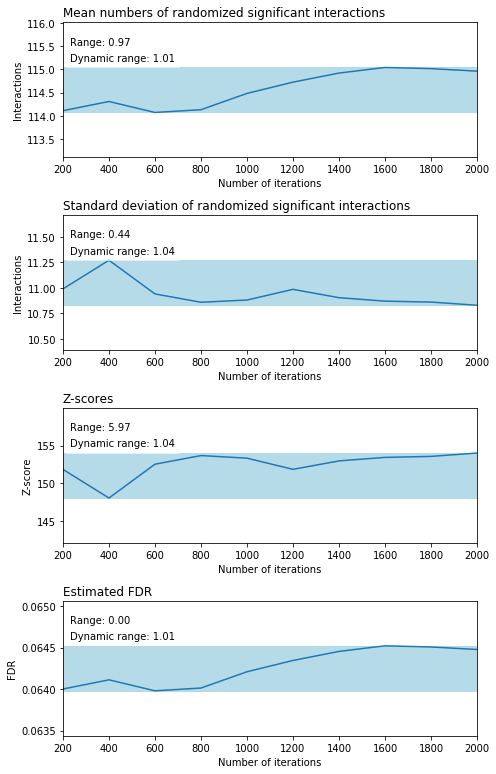

In [15]:
subplot_num = 4
fig, ax = plt.subplots(subplot_num, figsize=(7, subplot_num*2.715))
plt.setp(ax, xticks=iter_nums, xticklabels=iter_nums)

custom_plot(x = iter_nums, y = sig_num_r_means, ax = ax[0],
    title ='Mean numbers of randomized significant interactions',
    x_lab = 'Number of iterations',
    y_lab = 'Interactions')

custom_plot(x = iter_nums, y = sig_num_r_sds, ax = ax[1],
    title ='Standard deviation of randomized significant interactions',
    x_lab = 'Number of iterations',
    y_lab = 'Interactions')

custom_plot(x = iter_nums, y = z_scores, ax = ax[2],
    title ='Z-scores',
    x_lab = 'Number of iterations',
    y_lab = 'Z-score')

custom_plot(x = iter_nums, y = fdrs, ax = ax[3],
    title ='Estimated FDR',
    x_lab = 'Number of iterations',
    y_lab = 'FDR')

fig.tight_layout()

For the selected input and parameters, the mean, standard deviation, Z-score and FDR fluctuate only slightly, depending on the number of iterations.

## Results of the randomization depending on the number of input interactions

Next, we investigated how the results change for different numbers of input interactions. We use test files with ``1,000`` to ``64,000`` interactions. For each input file, we use a nominal alpha of ``0.005`` and perform ``2,000`` iterations.

In [16]:
# Input parameters
interaction_nums = [1000, 2000, 4000, 8000, 16000, 32000, 64000]
nominal_alpha = 0.005
iter_num = 2000

# Dictionary to save the results for increasing numbers of interactions
results_interaction_num = {}

# Perform randomization analyzes
for interaction_num in interaction_nums:
    i_file = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_' + str(interaction_num) + '.tsv.gz'
    print('Performing randomization analysis for ' + str(interaction_num) + ' interactions from:')
    print('\t' + i_file)
    i_set = DiachromaticInteractionSet()
    i_set.parse_file(i_file)
    r_analysis = RandomizeInteractionSet(interaction_set=i_set, random_seed=0)    
    results_interaction_num[interaction_num] = r_analysis.perform_randomization_analysis(
    nominal_alpha = nominal_alpha,
    iter_num = iter_num,
    thread_num = 2)
print('... done.')

Performing randomization analysis for 1000 interactions from:
	../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz
Performing randomization analysis for 2000 interactions from:
	../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000.tsv.gz
Performing randomization analysis for 4000 interactions from:
	../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000.tsv.gz
Performing randomization analysis for 8000 interactions from:
	../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000.tsv.gz
Performing randomization analysis for 16000 interactions from:
	../tests/data/test_03/diachromatic_interaction_file_fdr_top_16000.tsv.gz
Performing randomization analysis for 32000 interactions from:
	../tests/data/test_03/diachromatic_interaction_file_fdr_top_32000.tsv.gz
Performing randomization analysis for 64000 interactions from:
	../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
... done.


As before, we read the results for the various input files into separate lists and create plots using our custom plot function.

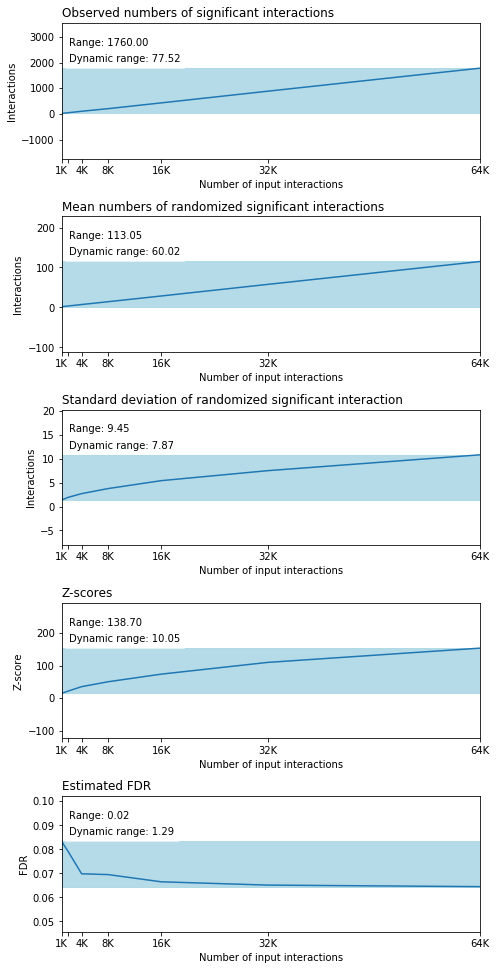

In [17]:
# Read results into separate lists
sig_num_os = []
sig_num_r_means = []
sig_num_r_sds = []
z_scores = []
fdr = []
for interaction_num in interaction_nums:
    sig_num_os.append(results_interaction_num[interaction_num]['RESULTS']['SUMMARY']['SIG_NUM_O'][0])    
    sig_num_r_means.append(results_interaction_num[interaction_num]['RESULTS']['SUMMARY']['SIG_NUM_R_MEAN'][0])
    sig_num_r_sds.append(results_interaction_num[interaction_num]['RESULTS']['SUMMARY']['SIG_NUM_R_STD'][0])    
    z_scores.append(results_interaction_num[interaction_num]['RESULTS']['SUMMARY']['Z_SCORE'][0])
    fdr.append(results_interaction_num[interaction_num]['RESULTS']['SUMMARY']['FDR'][0])

# Create a figure with custom plots
subplot_num = 5
fig, ax = plt.subplots(subplot_num, figsize=(7, subplot_num*2.715))
xtick_labels = ['1K','','4K','8K','16K','32K','64K']
plt.setp(ax, xticks=interaction_nums, xticklabels=xtick_labels)

custom_plot(x = interaction_nums, y = sig_num_os, ax = ax[0],
    title ='Observed numbers of significant interactions',
    x_lab = 'Number of input interactions',
    y_lab = 'Interactions')

custom_plot(x = interaction_nums, y = sig_num_r_means, ax = ax[1],
    title ='Mean numbers of randomized significant interactions',
    x_lab = 'Number of input interactions',
    y_lab = 'Interactions')

custom_plot(x = interaction_nums, y = sig_num_r_sds, ax = ax[2],
    title ='Standard deviation of randomized significant interaction',
    x_lab = 'Number of input interactions',
    y_lab = 'Interactions')

custom_plot(x = interaction_nums, y = z_scores, ax = ax[3],
    title ='Z-scores',
    x_lab = 'Number of input interactions',
    y_lab = 'Z-score')

custom_plot(x = interaction_nums, y = fdr, ax = ax[4],
    title ='Estimated FDR',
    x_lab = 'Number of input interactions',
    y_lab = 'FDR')

fig.tight_layout()

The number of observed significant interactions increases with the number of input interactions. The same is true for the number of randomized significant interactions, but this number increases somewhat more slowly (compare dynamic ranges). The standard deviation also increases with the number of input interactions, but much more slowly than the mean value, which results in increasing Z-scores. For the chosen nominal alpha of ``0.005``, the FDR decreases uo to ``4,000`` interactions and from then on stays between ``0.06`` and ``0.07``.

## Results of the randomization depending on the nominal alpha

In this section, we examine the relationship between the chosen nominal alpha and the numbers of observerd and randomized significant interactions as well the associated standard deviation, Z-score and FDR. In the previous analysis, we saw that the FDR is consistently greater than ``0.05`` with a chosen nominal alpha of ``0.005``. In this analysis we use nominal alphas between ``0.0005`` and ``0.005``, in order to get into a range where the FDR is below ``0.05``. For each nominal alpha, we use the input file with ``64,000`` interactions and perform ``2,000`` iterations.

In [18]:
# Input parameters
nominal_alphas = [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005]
iter_num = 2000

# Dictionary to save the results for increasing nominal alphas
results_nominal_alpha = {}

# Perform randomization analyzes
for nominal_alpha in nominal_alphas:   
    print('Performing randomization analysis with a nominal alpha of: ' + str(nominal_alpha) + ' ...')
    results_nominal_alpha[nominal_alpha] = randomization_analysis_64000.perform_randomization_analysis(
    nominal_alpha = nominal_alpha,
    iter_num = iter_num,
    thread_num = 2,
    verbose = False)
print('... done.')

Performing randomization analysis with a nominal alpha of: 0.0005 ...
Performing randomization analysis with a nominal alpha of: 0.001 ...
Performing randomization analysis with a nominal alpha of: 0.0015 ...
Performing randomization analysis with a nominal alpha of: 0.002 ...
Performing randomization analysis with a nominal alpha of: 0.0025 ...
Performing randomization analysis with a nominal alpha of: 0.003 ...
Performing randomization analysis with a nominal alpha of: 0.0035 ...
Performing randomization analysis with a nominal alpha of: 0.004 ...
Performing randomization analysis with a nominal alpha of: 0.0045 ...
Performing randomization analysis with a nominal alpha of: 0.005 ...
... done.


As before, we read the results for the various nominal alphas into separate lists and create plots using our custom plot function.

Largest nominal alpha for which the FDR is still below 0.05 (0.04537291933418694): 0.0035


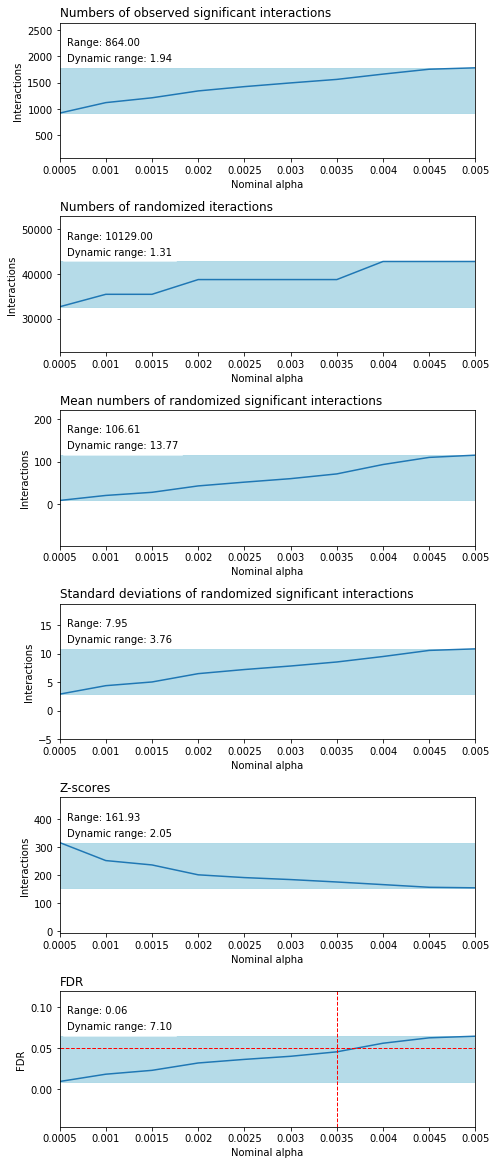

In [19]:
# Read results into separate lists
sig_num_os = []
i_num_r = []
sig_num_r_means = []
sig_num_r_sds = []
z_scores = []
fdrs = []
for nominal_alpha in nominal_alphas:
    sig_num_os.append(results_nominal_alpha[nominal_alpha]['RESULTS']['SUMMARY']['SIG_NUM_O'][0])
    i_num_r.append(results_nominal_alpha[nominal_alpha]['RESULTS']['SUMMARY']['I_NUM_RANDOMIZED'][0])    
    sig_num_r_means.append(results_nominal_alpha[nominal_alpha]['RESULTS']['SUMMARY']['SIG_NUM_R_MEAN'][0])
    sig_num_r_sds.append(results_nominal_alpha[nominal_alpha]['RESULTS']['SUMMARY']['SIG_NUM_R_STD'][0])    
    z_scores.append(results_nominal_alpha[nominal_alpha]['RESULTS']['SUMMARY']['Z_SCORE'][0])
    fdrs.append(results_nominal_alpha[nominal_alpha]['RESULTS']['SUMMARY']['FDR'][0])

# Find maximum nominal alpha with an FDR less than or equal to 0.05
idx = 0
for fdr in fdrs:
    if fdr <= 0.05:
        idx += 1
nominal_alpha_max_fdr = nominal_alphas[idx-1]

# Create a figure with custom plots
subplot_num = 6
fig, ax = plt.subplots(subplot_num, figsize=(7, subplot_num*2.715))
plt.setp(ax, xticks=nominal_alphas, xticklabels=nominal_alphas)

custom_plot(x = nominal_alphas, y = sig_num_os, ax = ax[0],
    title ='Numbers of observed significant interactions',
    x_lab = 'Nominal alpha',
    y_lab = 'Interactions')

custom_plot(x = nominal_alphas, y = i_num_r, ax = ax[1],
    title ='Numbers of randomized iteractions',
    x_lab = 'Nominal alpha',
    y_lab = 'Interactions')

custom_plot(x = nominal_alphas, y = sig_num_r_means, ax = ax[2],
    title ='Mean numbers of randomized significant interactions',
    x_lab = 'Nominal alpha',
    y_lab = 'Interactions')

custom_plot(x = nominal_alphas, y = sig_num_r_sds, ax = ax[3],
    title ='Standard deviations of randomized significant interactions',
    x_lab = 'Nominal alpha',
    y_lab = 'Interactions')

custom_plot(x = nominal_alphas, y = z_scores, ax = ax[4],
    title ='Z-scores',
    x_lab = 'Nominal alpha',
    y_lab = 'Interactions')

custom_plot(x = nominal_alphas, y = fdrs, ax = ax[5],
    title ='FDR',
    x_lab = 'Nominal alpha',
    y_lab = 'FDR')
ax[5].axhline(0.05, linestyle='--', color='red', linewidth=1)
ax[5].axvline(nominal_alpha_max_fdr, linestyle='--', color='red', linewidth=1)

fig.tight_layout()

print("Largest nominal alpha for which the FDR is still below 0.05 (" +
      str(fdrs[idx-1]) + "): " + str(nominal_alpha_max_fdr))

### Discussion of individual plots

The number of observerd significant interactions increases with increasing nominal alphas. This time, we also show the total number of randomized interactions because it depends on nominal alpha. We only randomize interactions that have enough read pairs to get a significant P-value. The number of required read pairs decreases in discrete steps of ``1``. Whenever that happens, additional interactions are randomized. For the data shown, this happens in three places: from ``0.0005`` to ``0.001``, from ``0.0015`` to ``0.002`` and from ``0.0035`` to ``0.004``. Like the number of observed significant interactions, the mean number of randomized significant interactions also increases with increasing nominal alpha, but much faster, which results in decreaing Z-scores and increasing FDRs. Also the standard deviation increases, but more slowly than the mean number of randomized significant interactions. The Z-score decreases with increasing nominal alpha because the number of observed significant interactions increases more slowly than the number of randomized significant interactions and because the standard deviation increases. The FDR increases for increasing nominal alpha because the number of observed significant interactions increases more slowly than the number of randomized significant interactions. The largest nominal alpha for which the FDR with ``0.04537`` is still below ``0.05`` is ``0.0035`` (red dashed lines).

## Relationship between FDR procedure and randomization study

### FDR procedure

If we apply the FDR procedure with an FDR threshold of ``0.05`` to the test file with ``64,000`` interactions, we get a P-value threshold of ``0.00325``.

In [20]:
# Input parameters for FDR
chosen_fdr_thresh = 0.05
p_value_max = 0.05
p_value_step = 0.00025

# Perform FDR procedure
fdr_info_dict_top_64000 = randomization_analysis_64000.get_pval_thresh_at_chosen_fdr_thresh(
    chosen_fdr_thresh = chosen_fdr_thresh,
    pval_thresh_max = p_value_max,
    pval_thresh_step_size = p_value_step,
    verbose = False)

# Print summary of results
print(randomization_analysis_64000.get_fdr_info_report())

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.05000
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 64,000
		[INFO] Random seed: 0
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00375
		[INFO] Determined -ln(P-value threshold): 5.58600
		[INFO] Minimum read pair number: 10
		[INFO] Smallest possible P-value with 10 read pairs: 0.00195
		[INFO] Number of interactions with 10 or more read pairs: 38,749
		[INFO] Number of significant interactions: 1,585
		[INFO] Number of randomized significant interactions: 77
		[INFO] Estimated FDR: 0.04858
[INFO] End of report.



At the determined P-value threshold of ``0.00375``, ``1585`` interactions are significant. For the FDR procedure, we randomize the interactions only once and, in this case, ``77`` randomized interactions are significant, so we estimate an FDR of ``77/1512 = 0.04858``.

### Randomization study with a nominal alpha of ``0.00375``

Now we perform ``2,000`` randomizations with a nominal alpha of ``0.00375``.

In [21]:
randomize_top_64000 = randomization_analysis_64000.perform_randomization_analysis(
    nominal_alpha = 0.00375,
    iter_num = 2000,
    thread_num = 2,
    verbose = True)
print(randomization_analysis_64000.get_randomization_info_report())

[INFO] Performing randomization analysis with 2000 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Performing 1000 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
		[INFO] Performing 1000 iterations ...
			[INFO] First iteration indices: 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, ...
	[INFO] Calculating summary statistics ...
[INFO] ... done.
[INFO] Report on randomization analysis:
	[INFO] Input parameters:
		[INFO] Number of input interactions: 64,000
		[INFO] Nominal alpha: 0.00375
		[INFO] Number of iterations: 2,000
		[INFO] Random seed: 0
	[INFO] Results:
		[INFO] Original number of significant interactions: 1,585
		[INFO] Number of randomized interactions: 38,749
		[INFO] First 10 significant randomized interaction numbers: 
			62, 67, 62, 84, 64, 61, 73, 73, 64, 81, ...
		[INFO] Iterations with more significant interactions than observed:

As before, ``1,585`` interactions are significant at this threshold but, in this case, we use the mean number of randomized significant interactions to estimate an FDR of ``74.35/1585 = 0.04691``, which is slightly lower than the previously estimated FDR.

### Randomization study with a nominal alpha of ``0.004``

Now we perform ``2,000`` randomizations with a nominal alpha of ``0.004``.

In [22]:
randomize_top_64000 = randomization_analysis_64000.perform_randomization_analysis(
    nominal_alpha = 0.004,
    iter_num = 2000,
    thread_num = 2,
    verbose = True)
print(randomization_analysis_64000.get_randomization_info_report())

[INFO] Performing randomization analysis with 2000 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Performing 1000 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
		[INFO] Performing 1000 iterations ...
			[INFO] First iteration indices: 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, ...
	[INFO] Calculating summary statistics ...
[INFO] ... done.
[INFO] Report on randomization analysis:
	[INFO] Input parameters:
		[INFO] Number of input interactions: 64,000
		[INFO] Nominal alpha: 0.00400
		[INFO] Number of iterations: 2,000
		[INFO] Random seed: 0
	[INFO] Results:
		[INFO] Original number of significant interactions: 1,663
		[INFO] Number of randomized interactions: 42,792
		[INFO] First 10 significant randomized interaction numbers: 
			100, 94, 86, 100, 101, 76, 98, 101, 69, 90, ...
		[INFO] Iterations with more significant interactions than obser

At this P-value threshold, we estimate an FDR that is greater than ``0.05``.

### FDR procedure with ``8,000,000`` interactions

Finally, we apply the FDR procedure to the test file with ``8,000,000``.

In [23]:
# Input parameters for FDR
chosen_fdr_thresh = 0.05
p_value_max = 0.05
p_value_step = 0.00025

# Prepare interaction set
interaction_file_top_8000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz'
interaction_set_top_8000000 = DiachromaticInteractionSet()
interaction_set_top_8000000.parse_file(interaction_file_top_8000000, verbose=False)

# Perform FDR procedure
randomize_fdr_top_8000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_8000000, random_seed=0)
fdr_info_dict_top_8000000 = randomize_fdr_top_8000000.get_pval_thresh_at_chosen_fdr_thresh(
    chosen_fdr_thresh = chosen_fdr_thresh,
    pval_thresh_max = p_value_max,
    pval_thresh_step_size = p_value_step,
    verbose = False)

# Print summary of results
fdr_info_report = randomize_fdr_top_8000000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.05000
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 8,000,000
		[INFO] Random seed: 0
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00375
		[INFO] Determined -ln(P-value threshold): 5.58600
		[INFO] Minimum read pair number: 10
		[INFO] Smallest possible P-value with 10 read pairs: 0.00195
		[INFO] Number of interactions with 10 or more read pairs: 4,886,564
		[INFO] Number of significant interactions: 196,005
		[INFO] Number of randomized significant interactions: 9,482
		[INFO] Estimated FDR: 0.04838
[INFO] End of report.



At an FDR threshold of ``0.05``, we determine a P-value threshold of ``0.00375``. At this threshold there are ``196,005`` significant interactions. In this case, there are ``9,482`` significant interactions after randomization. This gives an estimated FDR of ``9482/196005 = 0.04838``.

### Randomization study with a nominal alpha of ``0.00375`` and ``8,000,000``

Then we do the randomization study with a nominal alpha of ``0.00375``. We perform only ``10`` iterations because otherwise it will take too long.

In [24]:
randomize_top_8000000 = randomize_fdr_top_8000000.perform_randomization_analysis(
    nominal_alpha = 0.00375,
    iter_num = 10,
    thread_num = 2,
    verbose = True)
print(randomize_fdr_top_8000000.get_randomization_info_report())

[INFO] Performing randomization analysis with 10 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Performing 5 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, ...
		[INFO] Performing 5 iterations ...
			[INFO] First iteration indices: 5, 6, 7, 8, 9, ...
	[INFO] Calculating summary statistics ...
[INFO] ... done.
[INFO] Report on randomization analysis:
	[INFO] Input parameters:
		[INFO] Number of input interactions: 8,000,000
		[INFO] Nominal alpha: 0.00375
		[INFO] Number of iterations: 10
		[INFO] Random seed: 0
	[INFO] Results:
		[INFO] Original number of significant interactions: 196,005
		[INFO] Number of randomized interactions: 4,886,564
		[INFO] First 10 significant randomized interaction numbers: 
			9577, 9274, 9208, 9378, 9405, 9411, 9295, 9262, 9416, 9371, ...
		[INFO] Iterations with more significant interactions than observed: 0
		[INFO] Mean number of significant rand

The mean number of significant interactions after randomization is ``9,359.70``. This gives an estimated FDR of ``9359.70/196005 = 0.04775``.

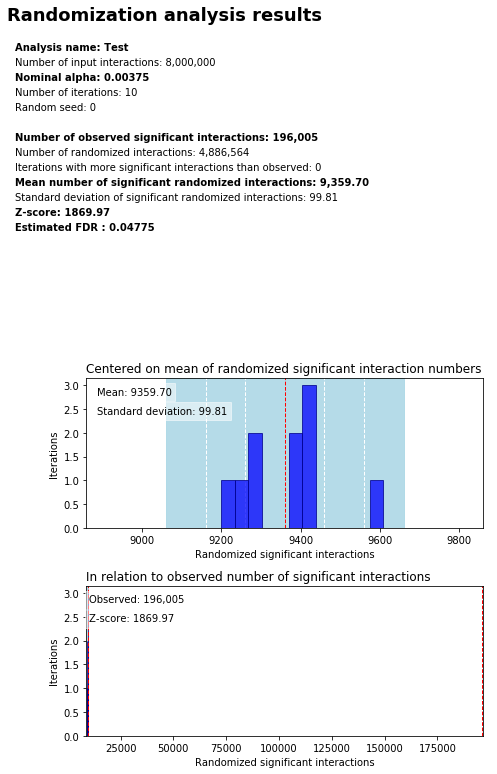

In [25]:
# Create plot with a histogram for the randomized significant interaction numbers from all iterations
fig = randomize_fdr_top_8000000.get_randomization_info_plot(
    pdf_file_name = 'randomization_analysis.pdf',
    analysis_name = 'Test')

## Script to run the randomization analysis

XXX

In [54]:
%matplotlib
%run ../02_perform_randomization_analysis.py \
--out-prefix DEMO \
--interaction-file ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz \
--nominal-alpha 0.00375 \
--thread-num 2 \
--iter-num 20

Using matplotlib backend: MacOSX
[INFO] Input parameters
	[INFO] --out-prefix: DEMO
	[INFO] --interaction-file: ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
	[INFO] --iter-num: 20
	[INFO] --nominal-alpha: 0.00375
	[INFO] --random-seed: None
	[INFO] --thread-num: 2

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
[INFO] ... done.
[INFO] Performing randomization analysis with 20 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Performing 10 iterations ...
			[INFO] First iteration indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
		[INFO] Performing 10 iterations ...
			[INFO] First iteration indices: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, ...
	[INFO] Calculating summary statistics ...
[INFO] ... done.


In [52]:
cat DEMO_randomization_analysis_summary.txt

[INFO] Input parameters
	[INFO] --out-prefix: DEMO
	[INFO] --interaction-file: ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
	[INFO] --iter-num: 20
	[INFO] --nominal-alpha: 0.00375
	[INFO] --random-seed: None
	[INFO] --thread-num: 2

[INFO] Report on randomization analysis:
	[INFO] Input parameters:
		[INFO] Number of input interactions: 64,000
		[INFO] Nominal alpha: 0.00375
		[INFO] Number of iterations: 20
		[INFO] Random seed: 1612274958
	[INFO] Results:
		[INFO] Original number of significant interactions: 1,585
		[INFO] Number of randomized interactions: 38,749
		[INFO] First 10 significant randomized interaction numbers: 
			70, 78, 65, 77, 72, 64, 79, 71, 79, 71, ...
		[INFO] Iterations with more significant interactions than observed: 0
		[INFO] Mean number of significant randomized interactions: 72.95
		[INFO] Standard deviation of significant randomized interactions: 6.60
		[INFO] Z-score: 229.13
		[INFO] Estimated FDR: 0.04603
[INFO] End of report

## ToDo

* Find out how to turn off matplotlibs's pop up winndows
* Finish the studies of the dependencies of iteration number, interaction number and nominal alpha on randomization.
* Also add random seeds for FDR procedure
    - Revise Jupyter notebook for FDR with respect to random seeds
* Integrate the randomization analysis into a separate script.
* Delete old modules.
* Finish this notebook.
* Have somone else check the code.
* Fix the problem with parallelization and ``time.sleep(1)``.
* Recalculate all results.